# Deploying the depression RNN in SageMaker

## Imports

In [17]:
import tensorflow as tf
import pandas as pd
import sagemaker
import os
from sagemaker.tensorflow import TensorFlow
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print('Done')

Done


## Data import
I joined both train and test data because I need to train the tokenizer later on this notebook. To keep things the same way that in the Kaggle notebook, I will use the same seed to split the data.

In [18]:
dataset = pd.read_csv('dataset.csv', sep=',')

## Creating a session object and uploading data to S3

In [19]:
sage_maker_session = sagemaker.Session()

In [20]:
#This returns the complete s3 path of the data file.
prefix = 'tensorflow-depression-predictions' #The name of the S3 bucket previously created
dataset_input_path = sage_maker_session.upload_data('dataset.csv', key_prefix=prefix+'/dataset')

In [21]:
dataset_input_path

's3://sagemaker-us-east-1-274416698914/tensorflow-depression-predictions/dataset/dataset.csv'

## Exploring the data coming from S3 to double check everything went OK

In [22]:
#Reading the csv file from S3
dataset = pd.read_csv(dataset_input_path, sep=',')

In [36]:
dataset.head()

,0,1
0,so when you ask what the two illnesses arethey...,0
1,in addition people with bpd quite often have a...,0
2,borderline personality disorder like all other...,0
3,long answer: bipolar disease is caused by a ch...,1
4,well think of bipolar as a rollar coaster you ...,0


In [39]:
dataset['0']

0       so when you ask what the two illnesses arethey...
1       in addition people with bpd quite often have a...
2       borderline personality disorder like all other...
3       long answer: bipolar disease is caused by a ch...
4       well think of bipolar as a rollar coaster you ...
                              ...                        
7138    please contact sadag (south african depression...
7139    it gave me severe ataxia (ataxia = people with...
7140    i have caused muscles to tense up swelling and...
7141    lamictal is my miracle medonly took me 26 year...
7142    i take wellbutrin topamax and buspar (antidepr...
Name: 0, Length: 7143, dtype: object

## Building the train.py file and saving it into the JupyterLab home dir

In [26]:
%%writefile train.py
import argparse
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=7)
    parser.add_argument('--max_words', type=int, default=20000)
    parser.add_argument('--max_len', type=int, default=400)
    parser.add_argument('--gpu_count', type=int, default=os.environ['SM_NUM_GPUS'])

    # input data and model directories
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args, _ = parser.parse_known_args()
    
    epochs     = args.epochs
    max_words  = args.max_words
    max_len    = args.max_len
    gpu_count  = args.gpu_count
    model_dir  = args.model_dir
    training_dir   = args.train
    
    data = pd.read_csv(training_dir+'/dataset.csv',sep=',')
    
    features = data['0'].values
    labels = data['1'].values
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(features)
    sequences = tokenizer.texts_to_sequences(features)
    features = pad_sequences(sequences, maxlen=max_len)

    vocab_size = len(tokenizer.word_index) 
    
    #Splitting the data again, because we needed to concat it before to train the tokenizer
    X_train, X_test, y_train, y_test = train_test_split(features,labels, random_state=0)

    # Building the model
    model = Sequential()
    model.add(layers.Embedding(max_words, 40))
    model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.5)))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=8,validation_data=(X_test, y_test))
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('Model accuracy: ',test_acc)
    
    model_path = '{}/{}/001'.format(model_dir, 'tensorflow-depression-predictions')
    tf.saved_model.save(model, model_path)

Overwriting train.py


In [27]:
tf_version = tf.__version__
tf_version

'2.1.0'

## Creating a training job on SageMaker
I'll use the previous train.py script that has all the required parameters to go through the RNN training.

In [28]:
role = sagemaker.get_execution_role()

In [29]:
#model_dir = '/opt/ml/model'
tf_estimator = TensorFlow(entry_point='train.py', 
                          role=role,
                          #model_dir=model_dir,
                          train_instance_count=1, 
                          train_instance_type='local',
                          framework_version=tf_version, 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 7,
                          }
                         )
# IMPORTANT: Only use *ml.p2.xlarge* instance type because it's the one that the limit has been increased.

In [30]:
#Starting the training, calling the fit method and passing the training and testing data paths. 
#This creates a training job on SageMaker. 
tf_estimator.fit({'train': dataset_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmph9z7gurk_algo-1-pyd3o_1 ... 
Attaching to tmph9z7gurk_algo-1-pyd3o_12mdone
algo-1-pyd3o_1  | 2020-09-17 18:47:31,820 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-pyd3o_1  | 2020-09-17 18:47:31,827 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-pyd3o_1  | 2020-09-17 18:47:33,029 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-pyd3o_1  | 2020-09-17 18:47:33,048 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-pyd3o_1  | 2020-09-17 18:47:33,067 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-pyd3o_1  | 2020-09-17 18:47:33,079 sagemaker-containers INFO     Invoking user script
algo-1-pyd3o_1  | 
algo-1-pyd3o_1  | Training Env:
algo-1-pyd3o_1  | 
algo-1-pyd3o_1  | {
algo-1-pyd3o_1  |     "additional_framework_parameters": {},
algo-1-pyd3o_1  |     "channel_input_dirs": {
algo-1-pyd3o_1  

## Deploying the model to SageMaker

In [31]:
endpoint_name = 'tensorflow-depression-predictions'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
end_point = tf_estimator.deploy(initial_instance_count=1,instance_type='ml.p2.xlarge',endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Attaching to tmppy5co3jo_algo-1-9g3ir_1
algo-1-9g3ir_1  | INFO:__main__:starting services
algo-1-9g3ir_1  | INFO:__main__:using default model name: tensorflow-depression-predictions
algo-1-9g3ir_1  | INFO:__main__:tensorflow serving model config: 
algo-1-9g3ir_1  | model_config_list: {
algo-1-9g3ir_1  |   config: {
algo-1-9g3ir_1  |     name: "tensorflow-depression-predictions",
algo-1-9g3ir_1  |     base_path: "/opt/ml/model/tensorflow-depression-predictions",
algo-1-9g3ir_1  |     model_platform: "tensorflow"
algo-1-9g3ir_1  |   }
algo-1-9g3ir_1  | }
algo-1-9g3ir_1  | 
algo-1-9g3ir_1  | 
algo-1-9g3ir_1  | INFO:__main__:nginx config: 
algo-1-9g3ir_1  | load_module modules/ngx_http_js_module.so;
algo-1-9g3ir_1  | 
algo-1-9g3ir_1  | worker_processes auto;
algo-1-9g3ir_1  | daemon off;
algo-1-9g3ir_1  | pid /tmp/nginx.pid;
algo-1-9g3ir_1  | error_log  /dev/stderr info;
algo-1-9g3ir_1  | 
algo-1-9g3ir_1  | worker_rlimit_nofile 4096;
algo-1-9g3ir_1  | 
algo-1-9g3ir_1  | events {
algo-1-9g3

In [32]:
print(end_point.endpoint)

tensorflow-depression-predictions2020-09-17-19-15-53


## Validating the model

In [51]:
#Splitting the data again, because we needed to concat it before to train the tokenizer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['0'],dataset['1'], random_state=0)

In [53]:
X_test.values

array(['they used to call it manic depression when i was young and didnt understand it well i have a foster nephew who is aggressive and he has been diagnosed as bp4 its a horrible disease and can be crippling for young people it is so hard when your friends dont "get" your moods i hope you find your safe place and coping mechanisms writing is one of mine and i have 4 cats and 4 dogs they help me on my down times bless you sweety you have a struggle ahead but we have people who will listen xxx',
       'i had testing in the fall there was a computer test and iq because even after being stable for a few years i was still having extreme difficulty focusing my results surprised me but showed adhd without a doubt and i was started on adderall adderall was the missing piece of the puzzle for me it made a huge difference in my life especially at work best of luck to you!!',
       'you have heard correctly it doesnt have to be that you get irritated and stay that way it can be a number of th

In [67]:
import pickle

def preprocess_texts(text):
    
    max_words = 20000
    max_len = 400

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(dataset['0'].values)
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=max_len)
    # saving tokenizer
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return sequences

In [68]:
test_texts = preprocess_texts(X_test.values)

In [69]:
len(test_texts)

1786

In [60]:
import numpy as np
predictions = end_point.predict(test_texts)

algo-1-9g3ir_1  | 172.18.0.1 - - [17/Sep/2020:19:31:02 +0000] "POST /invocations HTTP/1.1" 200 27961 "-" "-"


In [62]:
np.around(predictions['predictions'], decimals=0)

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [63]:
y_test

3895    0
1570    0
980     0
4666    1
1867    0
       ..
6901    0
4261    1
4548    1
700     1
6070    1
Name: 1, Length: 1786, dtype: int64

## Confusion matrix

In [65]:
import sklearn
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, np.around(predictions['predictions'], decimals=0))

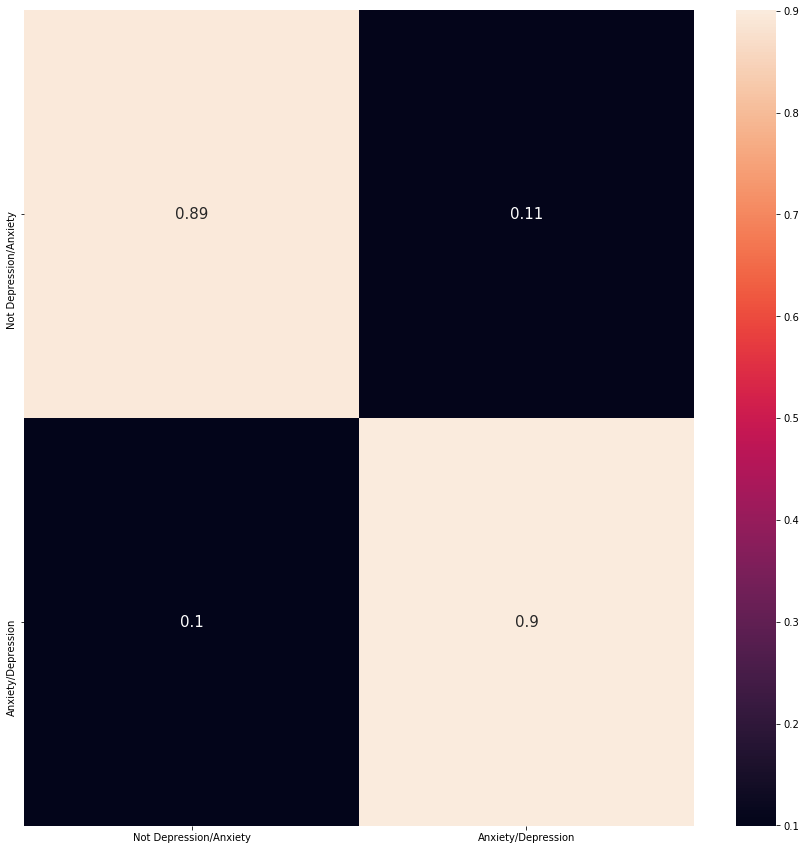

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Not Depression/Anxiety','Anxiety/Depression'],columns = ['Not Depression/Anxiety','Anxiety/Depression'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [70]:
# Make sure to call end_point.delete_endpoint()to delete the model endpoint.
# After go ahead and delete any files uploaded by sagemaker from your s3 bucket.
end_point.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
